In [1]:
%load_ext autoreload
%autoreload 2

import os
import gc
import math
import time
import random
random.seed(42)

import numpy as np
import pandas as pd
from scipy.special import expit as sigmoid

import PIL

from tqdm import tqdm
from attrdict import AttrDict

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K

try:
    import efficientnet.tfkeras as efn
except:
    !python3 -m pip install --user efficientnet attrdict
    import efficientnet.tfkeras as efn

from one_cycle_scheduler import *

In [2]:
num_workers = int(os.environ['SLURM_NNODES'])
node_id = int(os.environ['SLURM_NODEID'])

fold  = 3
kfold = 5
debug = True
batch_size = 80

In [3]:
CFG = AttrDict(
    batch_size       = batch_size,

    # Image sizes
    read_size        = 256, 
    crop_size        = 224, 
    net_size         = 224, 

    # Training Schedule
    LR_START         = 3e-3 * batch_size,
    LR_MAX           = 3e-2 * batch_size,
    LR_END           = 1e-2 * batch_size,
    LR_RAMPUP_EPOCHS = 0.5,
    epochs           = 5 if debug else 15,

    # Image Augmentation
    rot              = 180.0,
    shr              =   2.0,
    hzoom            =   8.0,
    wzoom            =   8.0,
    hshift           =   8.0,
    wshift           =   8.0,
    tta_steps        = 2 if debug else 4,

    optimizer        = tfa.optimizers.SGDW(lr=4e-2 * batch_size,
                                            nesterov=True,
                                            weight_decay=1e-5),
    label_smooth_fac = 0.05,
)

print(CFG)

AttrDict({'batch_size': 80, 'read_size': 256, 'crop_size': 224, 'net_size': 224, 'LR_START': 0.4, 'LR_MAX': 4.0, 'LR_END': 0.8, 'LR_RAMPUP_EPOCHS': 0.5, 'epochs': 15, 'rot': 180.0, 'shr': 2.0, 'hzoom': 8.0, 'wzoom': 8.0, 'hshift': 8.0, 'wshift': 8.0, 'tta_steps': 4, 'optimizer': <tensorflow_addons.optimizers.weight_decay_optimizers.SGDW object at 0x2aab6bec11d0>, 'label_smooth_fac': 0.05})


In [4]:
BASEPATH   = "/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/"
OUTPUTPATH = os.environ['SCRATCH'] + f"/summer_school/melanoma_f{fold}/"
print(f"Training with {BASEPATH} and saving at {OUTPUTPATH}")

df_train = pd.read_csv(BASEPATH + 'train.csv')
df_test  = pd.read_csv(BASEPATH + 'test.csv')
df_sub   = pd.read_csv(BASEPATH + 'sample_submission.csv')

files_test  = np.sort(tf.io.gfile.glob(BASEPATH + 'test*.tfrec'))
files_train = np.sort(tf.io.gfile.glob(BASEPATH + 'train*.tfrec'))

idx = np.arange(len(files_train))
files_valid = files_train[idx % kfold == fold]
files_train = files_train[idx % kfold != fold]

print('Validation:\n', files_valid)
print('Training:\n',   files_train)

Training with /scratch/snx3000/dealmeih/summer_school/melanoma-256x256/ and saving at /scratch/snx3000/dealmeih/summer_school/melanoma_f0/
Validation:
 ['/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train00-2182.tfrec'
 '/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train05-2171.tfrec'
 '/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train10-2174.tfrec']
Training:
 ['/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train01-2185.tfrec'
 '/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train02-2193.tfrec'
 '/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train03-2182.tfrec'
 '/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train04-2167.tfrec'
 '/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train06-2175.tfrec'
 '/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train07-2174.tfrec'
 '/scratch/snx3000/dealmeih/summer_school/melanoma-256x256/train08-2177.tfrec'
 '/scratch/snx3000/dealmeih/summer_school/mela

In [5]:
# sample some data
pd.read_csv(BASEPATH + 'train.csv').sample(frac=1, random_state=4)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
3627,ISIC_1195689,IP_6885799,female,45.0,lower extremity,unknown,benign,0
30580,ISIC_9240657,IP_7772951,male,45.0,NaN,unknown,benign,0
56,ISIC_0097499,IP_0414408,male,50.0,lower extremity,unknown,benign,0
30652,ISIC_9263944,IP_2101945,male,65.0,lower extremity,unknown,benign,0
24244,ISIC_7358425,IP_9896679,female,35.0,torso,unknown,benign,0
...,...,...,...,...,...,...,...,...
23346,ISIC_7096946,IP_5805281,male,50.0,torso,nevus,benign,0
11863,ISIC_3653492,IP_8051701,female,65.0,upper extremity,unknown,benign,0
27063,ISIC_8198182,IP_9362467,female,45.0,torso,unknown,benign,0
8366,ISIC_2609984,IP_2586665,female,45.0,torso,melanoma,malignant,1


In [6]:
# Disable greedy GPU memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

# default strategy (single node + single GPU, if available)
strategy = tf.distribute.get_strategy()
replicas = strategy.num_replicas_in_sync

print(replicas, gpus)

(1, [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [7]:
%%writefile siic_tfrec_dataset.py
import os
import re

import numpy as np
import tensorflow as tf

from PIL import ImageFont
from PIL import ImageDraw

from augmentation import *

AUTO = tf.data.experimental.AUTOTUNE

def get_dataset(files, cfg, augment=False, shuffle=False, repeat=False, 
                labeled=True, return_image_names=True):
    ''' instantiate a TFRecord dataset '''
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)

    if repeat:
        ds = ds.repeat()

    if shuffle: 
        ds = ds.shuffle(1024*5)
        opt = tf.data.Options()
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)

    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      

    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, cfg=cfg), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)

    # use global batch size here
    ds = ds.batch(cfg['batch_size'])
    ds = ds.prefetch(AUTO)
    return ds


def read_labeled_tfrecord(example):
    ''' parse training data '''
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['target']


def read_unlabeled_tfrecord(example, return_image_name):
    ''' parse test data '''
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    example = tf.io.parse_single_example(example, tfrec_format)
    return example['image'], example['image_name'] if return_image_name else 0


def prepare_image(img, cfg=None, augment=True):
    ''' decode and augment images '''
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [cfg['read_size'], cfg['read_size']])
    img = tf.cast(img, tf.float32) / 255.0

    if augment:
        img = transform(img, cfg)
        img = tf.image.random_crop(img, [cfg['crop_size'], cfg['crop_size'], 3])
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)
    else:
        img = tf.image.central_crop(img, cfg['crop_size'] / cfg['read_size'])

    if cfg['crop_size'] != cfg['net_size']:
        img = tf.image.resize(img, [cfg['net_size'], cfg['net_size']])
    img = tf.reshape(img, [cfg['net_size'], cfg['net_size'], 3])
    return img


def count_data_items(filenames):
    ''' count number of images in a set of TFRecords '''
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)


def show_dataset(thumb_size, cols, rows, ds):
    ''' create a grid of images from a TF dataset '''
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), 
                                             thumb_size*rows + (rows-1)))

    targets = []
    for idx, data in enumerate(iter(ds)):
        img, target_or_imgid = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        ImageDraw.Draw(img).text((4, 2), str(target_or_imgid.numpy()), (0,0,0))
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))

    display(mosaic)

Overwriting siic_tfrec_dataset.py


In [8]:
from siic_tfrec_dataset import get_dataset, count_data_items, show_dataset

ds_train = get_dataset(files_train, CFG, augment=True, shuffle=True, repeat=True)
ds_valid = get_dataset(files_valid, CFG, augment=False, shuffle=False, repeat=True)

steps_train = count_data_items(files_train) // CFG.batch_size
steps_valid = count_data_items(files_valid) // CFG.batch_size
if debug:
    steps_train = 50

print(f'Training for {steps_train} steps and ' +
      f'validating for {steps_valid} steps per epoch,'
      f'across {num_workers} node(s)')

Training for 327 steps and validating for 81 steps per epoch,across 2 node(s)


## Test the input pipeline

In [9]:
# ds = get_dataset(files_train, CFG, shuffle=True).unbatch().take(12*3)   
# show_dataset(64, 12, 3, ds)
# del ds

## Test image augmentation

In [10]:
# ds = tf.data.TFRecordDataset(files_train, num_parallel_reads=AUTO)
# ds = ds.take(1).repeat()
# ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
# ds = ds.map(lambda img, target: (prepare_image(img, cfg=CFG, augment=True), target), 
#             num_parallel_calls=AUTO)
# ds = ds.take(12*3)

# show_dataset(64, 12, 3, ds)
# del ds

## Images from the test data

In [11]:
# ds = get_dataset(files_test, CFG, labeled=False).unbatch().take(8*3)   
# show_dataset(96, 8, 3, ds)
# del ds

# Model

In [16]:
%%writefile deep_binary_classifier.py
import os
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn

def get_model(cfg, backbone, drop_rate=0.3, **kwargs):
    ''' create typical transfer learning model with a given backbone '''
    model_input = tf.keras.Input(shape=(cfg['net_size'], cfg['net_size'], 3), name='in')
    outputs = []

    x = backbone(include_top=False,
                 input_shape=(cfg['net_size'], cfg['net_size'], 3),
                 **kwargs)(model_input)

    x = tf.keras.layers.Dropout(rate=drop_rate, name='top_dropout')(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    model = tf.keras.Model(model_input, x, name='EfficientNet')

    model.summary()
    return model

def compile_new_model(cfg,
                      backbone=efn.EfficientNetB0,
                      weights='noisy-student',
                      **kwargs):
    ''' create and compile a binary classifier '''
    model = get_model(cfg,
                      backbone=backbone,
                      weights=weights,
                      **kwargs)
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=cfg['label_smooth_fac'])

    model.compile(
        optimizer = cfg['optimizer'],
        loss      = loss,
        metrics   = [tf.keras.metrics.AUC(name='auc')])

    return model

Overwriting deep_binary_classifier.py


In [17]:
from deep_binary_classifier import compile_new_model

with strategy.scope():
    model = compile_new_model(CFG,
                              efn.EfficientNetB2,
                              BASEPATH + '../efficientnet-b2_noisy-student_notop.h5',
                              pooling='avg',
                             )

# EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks
# https://arxiv.org/pdf/1905.11946.pdf

Model: "EfficientNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
in (InputLayer)              [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnet-b2 (Model)      (None, 1408)              7768562   
_________________________________________________________________
top_dropout (Dropout)        (None, 1408)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1409      
Total params: 7,769,971
Trainable params: 7,702,403
Non-trainable params: 67,568
_________________________________________________________________


In [18]:

# Log loss and metric history in TensorBoard format
tb_logdir = OUTPUTPATH + 'logs'
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=tb_logdir, update_freq=50,
                                                histogram_freq=0, profile_batch=0)

# In TF <=2.2 ModelCheckpoint allows fault tolerance
# in cases where workers die or are otherwise unstable.
# We do this by preserving training state in the distributed file system of your choice,
# such that upon restart of the instance that previously failed or preempted,
# the training state is recovered.
checkpoint_path = OUTPUTPATH + 'weights{epoch:03d}-auc{val_auc:.05f}.h5'
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    save_best_only=True,
    verbose=1, monitor='val_auc', mode='max',
)

# Stops training if metric dosen't improve for 'patience' epoches
stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_auc', min_delta=1e-5,
                                               mode='max', patience=CFG.epochs//2, verbose=1,
                                               restore_best_weights=True)

# LR and momentum scheduler
lr_sched_cb = OneCycleScheduler(lr_max=CFG.LR_MAX,
                                steps=CFG.epochs * steps_train,
                                mom_min=0.85, mom_max=0.95,
                                phase_1_pct=CFG.LR_RAMPUP_EPOCHS / CFG.epochs,
                                div_factor=CFG.LR_MAX / CFG.LR_START,
                                final_div_factor=CFG.LR_MAX / CFG.LR_END)

# lr_sched_cb = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='auto', verbose=1,
#                                                    factor=0.3, patience=2, cooldown=1,
#                                                    min_delta=1e-4, min_lr=1e-8)

# Nicer progress output, both on jupyter and console
tqdm_progbar = tfa.callbacks.TQDMProgressBar()

callbacks = [tensorboard_cb, checkpoint_cb, stopping_cb, lr_sched_cb, tqdm_progbar]

In [19]:
!rm -rf {tb_logdir}

from tb_cscs import tensorboard
%tensorboard  --logdir={tb_logdir}  --host localhost

In [20]:
history = model.fit(ds_train, 
                    verbose          = 0, # use TQDMProgressBar instead
                    steps_per_epoch  = steps_train,
                    epochs           = CFG.epochs,
                    validation_data  = ds_valid,
                    validation_steps = steps_valid,
                    callbacks        = callbacks
                   )

Epoch 1/15



Epoch 00001: val_auc improved from -inf to 0.37116, saving model to /scratch/snx3000/dealmeih/summer_school/melanoma_f0/weights001-auc0.37116.h5

Epoch 2/15



Epoch 00002: val_auc improved from 0.37116 to 0.76932, saving model to /scratch/snx3000/dealmeih/summer_school/melanoma_f0/weights002-auc0.76932.h5

Epoch 3/15



Epoch 00003: val_auc improved from 0.76932 to 0.84327, saving model to /scratch/snx3000/dealmeih/summer_school/melanoma_f0/weights003-auc0.84327.h5

Epoch 4/15



Epoch 00004: val_auc did not improve from 0.84327

Epoch 5/15



Epoch 00005: val_auc improved from 0.84327 to 0.84449, saving model to /scratch/snx3000/dealmeih/summer_school/melanoma_f0/weights005-auc0.84449.h5

Epoch 6/15



Epoch 00006: val_auc improved from 0.84449 to 0.86103, saving model to /scratch/snx3000/dealmeih/summer_school/melanoma_f0/weights006-auc0.86103.h5

Epoch 7/15



Epoch 00007: val_auc did not improve from 0.86103

Epoch 8/15



Epoch 00008: val_auc did not improve from 0.86103

Epoch 9/15



Epoch 00009: val_auc improved from 0.86103 to 0.87142, saving model to /scratch/snx3000/dealmeih/summer_school/melanoma_f0/weights009-auc0.87142.h5

Epoch 10/15



Epoch 00010: val_auc improved from 0.87142 to 0.87627, saving model to /scratch/snx3000/dealmeih/summer_school/melanoma_f0/weights010-auc0.87627.h5

Epoch 11/15



Epoch 00011: val_auc improved from 0.87627 to 0.88836, saving model to /scratch/snx3000/dealmeih/summer_school/melanoma_f0/weights011-auc0.88836.h5

Epoch 12/15



Epoch 00012: val_auc did not improve from 0.88836

Epoch 13/15



Epoch 00013: val_auc did not improve from 0.88836

Epoch 14/15



Epoch 00014: val_auc did not improve from 0.88836

Epoch 15/15



Epoch 00015: val_auc improved from 0.88836 to 0.88989, saving model to /scratch/snx3000/dealmeih/summer_school/melanoma_f0/weights015-auc0.88989.h5




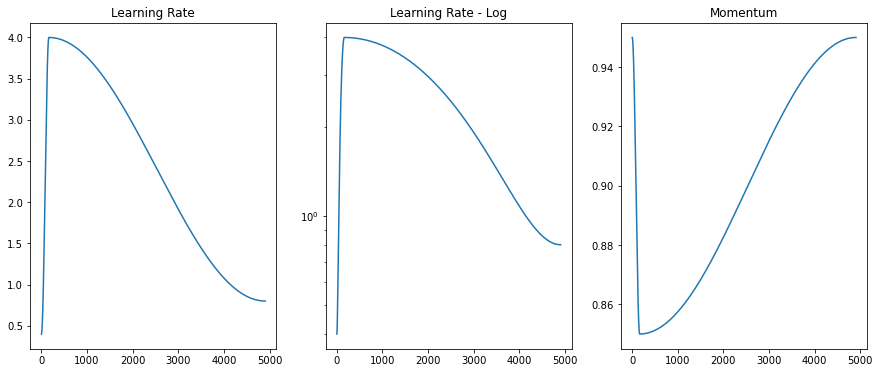

In [21]:
if hasattr(lr_sched_cb, 'plot'):
    lr_sched_cb.plot()

### predict the test set using augmented images

In [22]:
CFG['batch_size'] = 256

cnt_test   = count_data_items(files_test)
steps      = cnt_test / (CFG['batch_size']) * CFG['tta_steps']
ds_testAug = get_dataset(files_test, CFG, augment=True, repeat=True, 
                         labeled=False, return_image_names=False)

probs = model.predict(ds_testAug, verbose=1, steps=steps)
probs = probs[:cnt_test * CFG['tta_steps']].reshape(CFG['tta_steps'], cnt_test)
probs = np.mean(probs, axis=0)

172/171 [==============================] - 56s 326ms/step


### sort predictions to have the same order as the submission
The submission ist sorted by image_name, but the dataset yielded a different order.
Traverse the test dataset once again and capture the image_names. Then join this list of image_names with the predictions and sort by image_name.

In [23]:
ds = get_dataset(files_test, CFG, augment=False, repeat=False, 
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

,image_name,target
9905,ISIC_0052060,0.022893
1443,ISIC_0052349,0.023226
3120,ISIC_0058510,0.023425
4870,ISIC_0073313,0.024593
5494,ISIC_0073502,0.034360
...,...,...
5994,ISIC_9992485,0.023204
3980,ISIC_9996992,0.037673
6974,ISIC_9997917,0.047831
1278,ISIC_9998234,0.028712


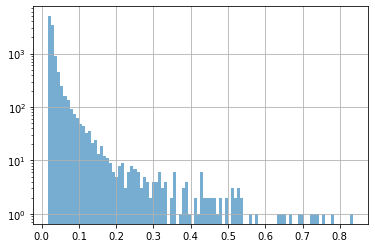

In [24]:
submission = pd.DataFrame(dict(
    image_name = image_names,
    target     = probs))

submission.target.hist(bins=100, log=True, alpha=0.6)

submission = submission.sort_values('image_name')
submission.to_csv('submission.csv', index=False)

submission

In [25]:
!ls -sh {OUTPUTPATH}

total 266M
4.0K logs		        31M weights006-auc0.86103.h5
 31M weights001-auc0.37116.h5   31M weights009-auc0.87142.h5
 31M weights002-auc0.76932.h5   31M weights010-auc0.87627.h5
 31M weights003-auc0.84327.h5   25M weights011-auc0.88836.h5
 31M weights005-auc0.84449.h5   31M weights015-auc0.88989.h5


In [26]:
df_sub = pd.read_csv(os.path.join(BASEPATH, 'sample_submission.csv'))
assert len(submission) == len(df_sub)